In [47]:
import itertools
import networkx as nx
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import LinearRegression

 #### Erdös-Rényi (ER) networks

In [19]:
def erdos_renyi_gen(n,p):
    net = nx.Graph()
    for node in range(0,n):
        net.add_node(node)
    
    for ini in range(0,n):
        for end in range(ini+1, n):
            if (p > 0 and random.random() <= p):
                net.add_edge(ini, end)
    return net

def erdos_renyi_gen_plot(n,p):
    net = erdos_renyi_gen(n, p)

    # nx.draw(net)
    # plt.show()

    # Actual and theoretical average degree
    k = sum([d[1] for d in net.degree()])/n
    k_theo = p*(n-1)
    
    # Actual and theoretical degree distribution
    h = nx.degree_histogram(net)
    h_theo = []

    for deg in range(len(h)):
        #Poisson distribution
        h_theo.append(math.exp(-k_theo)*k_theo**deg/math.factorial(deg))

    plt.plot(np.asarray(h)/float(sum(h)), 's-', label='Actual data')
    plt.axvline(x=k, ls='dashed', label=f'Experimental <k>={k}')
    plt.plot(h_theo, 'o-', color='r', label='Poisson approximation')
    plt.axvline(x=k_theo, color='r', ls='dashed', label=f'Theoretical <k>={k_theo}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

    plt.title(f'Erdös-Rényi N={n} and p={p}')
    plt.grid(True)

    plt.show() 


 #### Watts-Strogatz model (WS)

In [20]:
def watts_strogatz_gen(n, k, p):
    if (k >= n): 
        raise Exception('Invalid value for k. k must be less than n')

    net = nx.Graph()
    k_2 = math.floor(k / 2)
    edge_list = []

    for node in range(0,n):
        for node_pos_shift in range(1, k_2 + 1):
            edge_list.append([node, (node + node_pos_shift) % n])

    net.add_edges_from(edge_list)

    for edge in edge_list:
        if (p > 0 and random.random() < p):
            new_to = random.randint(0, n-1)

            while new_to == edge[1] or net.has_edge(edge[0], new_to):
                new_to = random.randint(0, n-1)

            if net.degree(edge[0]) >= n - 1:
                break
            else:
                net.remove_edge(edge[0], edge[1])
                net.add_edge(edge[0], new_to)
    
    return net

def watts_strogatz_plot(n, k, p):
    net = watts_strogatz_gen(n, k, p)

    h = nx.degree_histogram(net)
    h_theo = []

    for deg in range(len(h)):
        #Poisson distribution
        h_theo.append(math.exp(-k)*k**deg/math.factorial(deg))

    plt.plot(np.asarray(h)/float(sum(h)), 's-', label='Actual data')
    plt.plot(h_theo, 'o-', color='r', label='Poisson approximation')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

    plt.title(f'Watts-Strogatz N={n}, k={k} and p={p}')
    plt.grid(True)
    plt.show()



 ##### Barabási-Albert model (BA)

In [55]:
def barabasi_albert_gen(n, m0, m):
    if (m0 > n):
        raise Exception('m0 must be equal or less than n.')

    if (m > m0):
        raise Exception('m must be equal or less than m0.')

    net = nx.Graph()

    for node in range(0,m0):
        #print(f'Adding node {node}')
        net.add_node(node)

    #Generating a list (circular) with m0 nodes
    edge_list = []
    for node in range(0,m0):
        for node_pos_shift in range(1, 3):
            edge_list.append([node, (node + node_pos_shift) % m0])

    net.add_edges_from(edge_list)

    while m0 < n:    
        distr_degree = []
        for degree in net.degree():
            distr_degree += [degree[0]] * degree[1]

        for _ in range(0, m):
            node = random.choice(distr_degree)
            distr_degree = [item for item in distr_degree if item != node]

            net.add_node(m0)
            net.add_edge(m0, node)     
        m0 += 1

    return net

def barabasi_albert_plot(n, m0, m):
    net = barabasi_albert_gen(n,m0,m)

    degree_histogram = nx.degree_histogram(net)
    
    h_ = [i for i in degree_histogram if i>0]
    degreedistribution = np.asarray([math.log(float(i)/sum(h_)) for i in h_])
    d_ = np.asarray([math.log(i) for i in range(len(degree_histogram)) if degree_histogram[i]>0]).reshape((len(h_),1))
    lr = LinearRegression()
    lr.fit(d_, degreedistribution)
    gamma = -lr.coef_

    plt.scatter([math.exp(i) for i in d_], [math.exp(j) for j in degreedistribution],  color='blue', label='Actual data')
    plt.plot([math.exp(i) for i in d_], [math.exp(j) for j in lr.predict(d_)], color='black', linewidth=2, label='Regression')
    plt.xscale('log')
    plt.yscale('log')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(f'Barabási-Albert N={n}, m0={m0} and {m}. Estimated γ={gamma}')
    plt.grid(True)
    plt.show()

In [22]:
for n in [50, 100]:
    for p in [.2, .5, .7]:
        net = erdos_renyi_gen(n, p)
        nx.write_pajek(net, f'./output/ER_n_{n}_p_{100*p}.net')


In [23]:
for n in [50, 100]:
    for p in [0, .1, .2, .5, 0.9, 1.0]:
        watts_strogatz_gen(n, 4, p)
        nx.write_pajek(net, f'./output/WS_n_{n}_p_{100*p}.net')


In [24]:
for n in [100]:
    for m in [1, 2, 5]:
        barabasi_albert_gen(n, n//2, m)
        nx.write_pajek(net, f'./output/BA_n_{n}_m_{m}_m0_{n//2}.net')




In [44]:
barabasi_albert_plot(1000, 50, 1)
#barabasi_albert_plot(1000, 50, 5)
#barabasi_albert_plot(1000, 50, 10)
#barabasi_albert_plot(10000, 100, 1)
#barabasi_albert_plot(10000, 100, 5)
#barabasi_albert_plot(10000, 100, 10)

AttributeError: module 'sklearn' has no attribute 'linear_model'

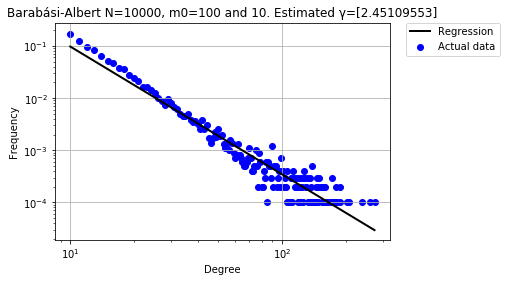

In [60]:
barabasi_albert_plot(10000, 100, 10)